In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

import seaborn as sns

import lightgbm as lgbm

In [2]:
def gen_data(n=2000, supplementers=4, substitutes=4):
    supp_cols = np.random.rand(n, supplementers)
    if supp_cols.shape[1]:
        _base_arr = np.concatenate(
            [np.random.rand(n, 2), supp_cols.prod(axis=1).reshape(n, 1)], axis=1
        )
    else:
        _base_arr = np.random.rand(n, 2)

    true_model = GradientBoostingRegressor(n_estimators=15).fit(
        _base_arr, np.random.rand(n)
    )

    y_arr = true_model.predict(_base_arr)

    widened_arr = np.repeat(_base_arr[:, 0], substitutes).reshape(n, substitutes)

    x_df = (
        pd.DataFrame(
            np.random.normal(loc=widened_arr, scale=0.05),
            columns=[f"sub{i}" for i in range(1, substitutes + 1)],
        )
        .assign(lone=_base_arr[:, 1])
        .pipe(
            lambda df: pd.concat(
                [
                    df,
                    pd.DataFrame(
                        supp_cols,
                        columns=[f"sup{i}" for i in range(1, substitutes + 1)],
                    ),
                ],
                axis=1,
            )
        )
    )

    return x_df, y_arr

In [3]:
from tqdm.notebook import tqdm

In [4]:
def measure_recs(iters=200, subs=2, sups=2):
    recs = []
    for run_id in tqdm(list(range(iters))):

        x_df, y_arr = gen_data(supplementers=sups, substitutes=subs)

        for todrop in [[]] + x_df.columns.tolist():

            x_train, x_test, y_train, y_test = train_test_split(
                x_df.drop(todrop, axis=1), y_arr
            )

            model = GradientBoostingRegressor(n_estimators=1000, n_iter_no_change=5).fit(
                x_train, y_train
            )

            recs.append(
                {
                    **pd.Series(
                        model.feature_importances_, index=x_train.columns
                    ).to_dict(),
                    "train_score": model.score(x_train, y_train),
                    "test_score": model.score(x_test, y_test),
                    "run_id": run_id,
                    "dropped": todrop if todrop else "none",
                }
            )
    return pd.DataFrame(recs)

In [5]:
measures = []

In [33]:
for bs in range(2, 7):

    metrics = measure_recs(800, bs, bs)

    _mdf = (
        metrics.pivot_table(index="run_id", columns="dropped", values="test_score")
        .pipe(lambda df: df - df.loc[:, ["none"]].values)
        .drop(["lone", "none"], axis=1)
        .melt()
        .assign(dropped_cat=lambda df: df["dropped"].str[:3])
        .groupby("dropped_cat")["value"]
        .agg(["mean", "std"])
        .join(
            metrics.loc[lambda df: df["dropped"] == "none", :"train_score"]
            .drop(["train_score", "lone"], axis=1)
            .melt()
            .assign(feature_imp=lambda df: df["variable"].str[:3])
            .groupby("feature_imp")["value"]
            .agg(["mean", "std"])
            .rename(columns=lambda s: f"fi-{s}")
        )
    ).assign(bs=bs)
    measures.append(_mdf)

In [37]:
pd.concat(measures).reset_index().pivot_table(index="bs", columns="dropped_cat")

fi-mean              fi-std                mean            \
dropped_cat       sub       sup       sub       sup       sub       sup   
bs                                                                        
2            0.116498  0.137745  0.119046  0.134958  0.002070 -0.012635   
3            0.086436  0.077889  0.100712  0.094421 -0.002214 -0.002089   
4            0.074225  0.051948  0.093493  0.072719  0.002355  0.002340   
5            0.063602  0.038035  0.082500  0.062546  0.000928  0.001717   
6            0.053993  0.030052  0.077277  0.053518 -0.000439 -0.000251   

                  std            
dropped_cat       sub       sup  
bs                               
2            0.087474  0.090229  
3            0.082648  0.088769  
4            0.080198  0.080413  
5            0.085948  0.086772  
6            0.081835  0.082525

In [6]:
x_df, y_arr = gen_data(supplementers=4, substitutes=4)

x_train_full, x_test, y_train_full, y_test = train_test_split(x_df, y_arr)

x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full)

model = lgbm.LGBMRegressor(n_estimators=300).fit(
    x_train, y_train, early_stopping_rounds=30, eval_metric="rmse", eval_set=[(x_valid, y_valid)],
)

[1]	valid_0's rmse: 0.0198165	valid_0's l2: 0.000392695
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 0.0190008	valid_0's l2: 0.00036103
[3]	valid_0's rmse: 0.018326	valid_0's l2: 0.000335844
[4]	valid_0's rmse: 0.017701	valid_0's l2: 0.000313327
[5]	valid_0's rmse: 0.0172513	valid_0's l2: 0.000297608
[6]	valid_0's rmse: 0.0168288	valid_0's l2: 0.000283207
[7]	valid_0's rmse: 0.0164562	valid_0's l2: 0.000270808
[8]	valid_0's rmse: 0.0161978	valid_0's l2: 0.000262367
[9]	valid_0's rmse: 0.0159572	valid_0's l2: 0.000254631
[10]	valid_0's rmse: 0.0158236	valid_0's l2: 0.000250386
[11]	valid_0's rmse: 0.0156952	valid_0's l2: 0.00024634
[12]	valid_0's rmse: 0.0155806	valid_0's l2: 0.000242755
[13]	valid_0's rmse: 0.0155164	valid_0's l2: 0.000240759
[14]	valid_0's rmse: 0.0155161	valid_0's l2: 0.000240748
[15]	valid_0's rmse: 0.0154867	valid_0's l2: 0.000239838
[16]	valid_0's rmse: 0.0154604	valid_0's l2: 0.000239025
[17]	valid_0's rmse: 0.0154468	valid_0's

In [7]:
{
    "train_score": model.score(x_train, y_train),
    "test_score": model.score(x_test, y_test),
}

{'train_score': 0.6146591558022805, 'test_score': 0.37156254413528367}

In [8]:
tree_df = model.booster_.trees_to_dataframe()

In [9]:
tree_df["decision_type"].value_counts()

<=    690
Name: decision_type, dtype: int64

In [10]:
tree_df["split_feature"].value_counts()

lone    145
sup2    103
sup1     91
sup4     80
sup3     69
sub3     61
sub1     48
sub4     47
sub2     46
Name: split_feature, dtype: int64

In [11]:
child_map = (
    tree_df.pipe(
        lambda df: df.loc[:, ["node_index", "split_feature"]].merge(
            df.loc[:, ["parent_index", "split_feature"]].rename(
                columns={"parent_index": "node_index", "split_feature": "child_feature"}
            )
        )
    )
    .drop("node_index", axis=1)
    .apply(lambda s: s.str[:3])
    .assign(C=1)
    .groupby(["split_feature", "child_feature"])
    .sum()
    .reset_index()
    .pivot_table(columns="child_feature", index="split_feature", values="C")
)

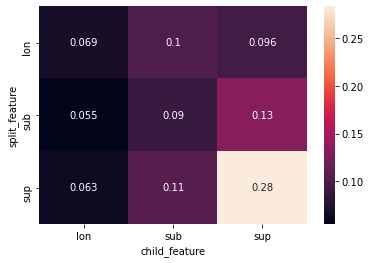

In [12]:
sns.heatmap(child_map.pipe(lambda df: df / df.sum().sum()), annot=True)